In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

This is just a mess of stuff I've been doing while I've been researching stuff

# vv HEY HENGJUN ITS THIS ONE vv

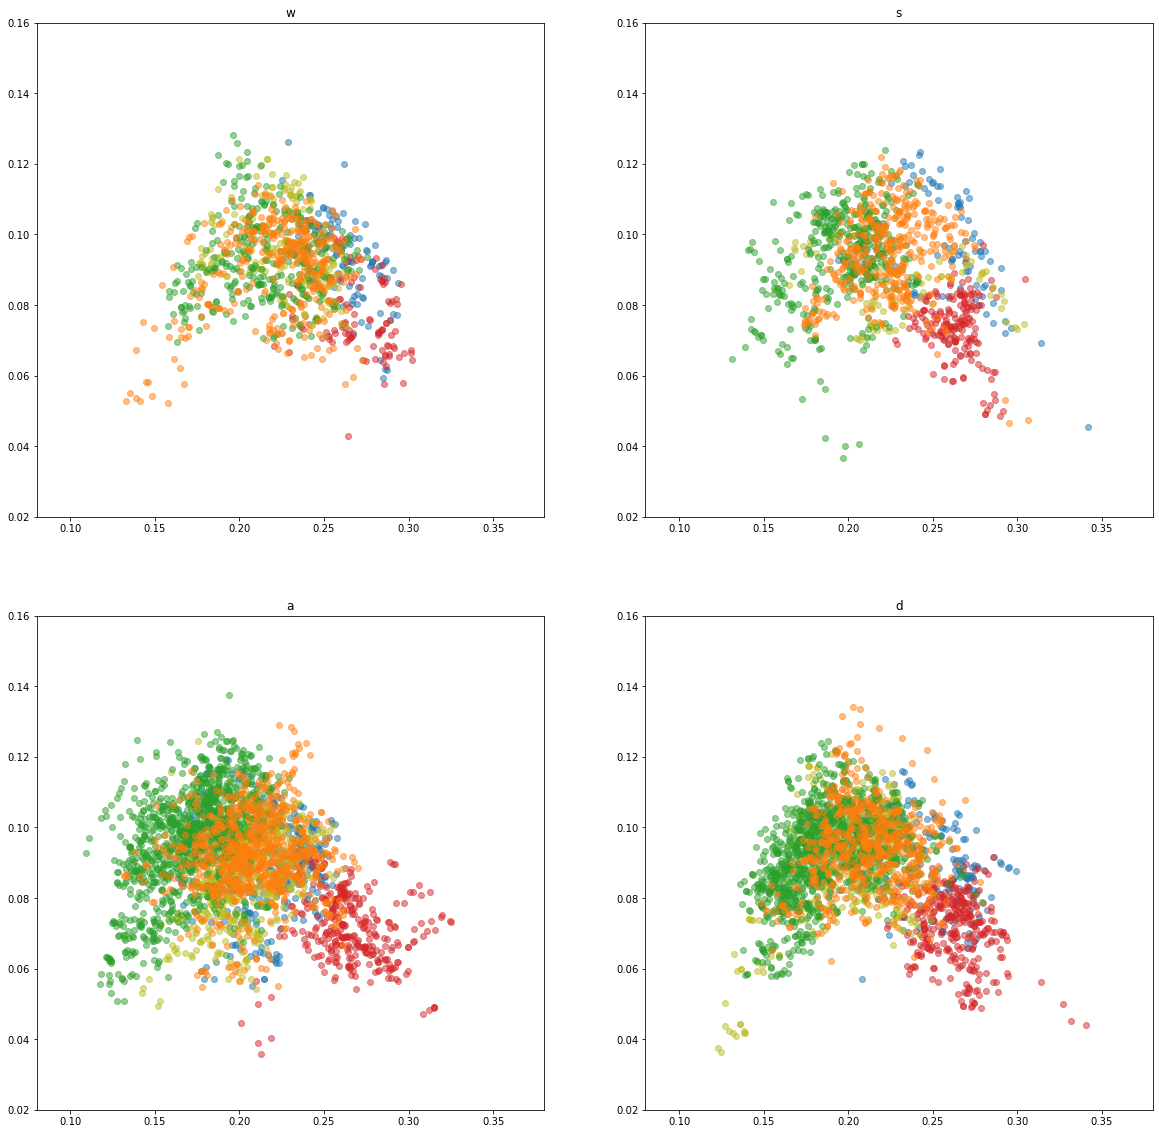

In [56]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from log_parser import parse_keyboard_log
from numpy_ringbuffer import RingBuffer


sample_size = 20
labels = ['HEN', 'ZIR', 'JOS', 'MAR', 'MIT'] # Left out Jon bc he has no SOL logfile
# Also I should just change this to use the routing file but it is what it is

# Creates 4 subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

for name in labels: # For each name listed above:

    # Convert the logfile to a DataFrame
    kb = parse_keyboard_log(f"logs/{name}/SOL/key.log")

    durations_dict = {} # Poorly named dict that maps each key to a ring buffer of size [sample_size]
    presstimes = {}     # Record the 'last pressed' time of each key
    duration_data = {}  # Records the mean/std of each key sample in the log
    
    # Analyze each piece of data one at a time
    for _, row in kb.iterrows():
        key = str(row.key).replace('\'', '') # Get rid of 's

        if key not in durations_dict.keys():   # If key has not been pressed
            # Init key in durations dicts
            durations_dict[key] = RingBuffer(capacity=sample_size, dtype=float)
            duration_data[key] = [[], []]
        
        if row.action == 'pressed':     # If key was pressed
            presstimes[key] = row.time  # Record time of press
        
        # If key was released and it has been pressed before
        elif row.action == 'released' and key in presstimes.keys():
            duration = row.time - presstimes[key] # Calculate press duration

            if duration < 0.4: # Only append key taps (<0.4s)
                durations_dict[key].append(duration) # Append to ring buffer

                durations_np = np.array(durations_dict[key]) # Convert to numpy array
                if durations_np.size > 3:
                    duration_data[key][0].append((durations_np.mean(), durations_np.std()))
                    duration_data[key][1].append('Hengjun')

    # I got pretty lazy here but it works lol
    color = 'black'
    if name == 'HEN':
        color = 'tab:blue'
    if name == 'ZIR':
        color = 'tab:red'
    if name == 'JOS':
        color = 'tab:olive'
    if name == 'MAR':
        color = 'tab:green'
    if name == 'MIT':
        color = 'tab:orange'
    if name == 'JON':
        color = 'tab:purple'

    # Each call to scatter() on the same axes just draws more points on top of it
    ax[0][0].set_title('w')
    ax[0][0].set_xlim(0.08, 0.38)
    ax[0][0].set_ylim(0.02, 0.16)
    ax[0][0].scatter([x for x, _ in duration_data['w'][0]], [y for _, y in duration_data['w'][0]], c=color, alpha=0.5)

    ax[1][0].set_title('a')
    ax[1][0].set_xlim(0.08, 0.38)
    ax[1][0].set_ylim(0.02, 0.16)
    ax[1][0].scatter([x for x, _ in duration_data['a'][0]], [y for _, y in duration_data['a'][0]], c=color, alpha=0.5)

    ax[0][1].set_title('s')
    ax[0][1].set_xlim(0.08, 0.38)
    ax[0][1].set_ylim(0.02, 0.16)
    ax[0][1].scatter([x for x, _ in duration_data['s'][0]], [y for _, y in duration_data['s'][0]], c=color, alpha=0.5)

    ax[1][1].set_title('d')
    ax[1][1].set_xlim(0.08, 0.38)
    ax[1][1].set_ylim(0.02, 0.16)
    ax[1][1].scatter([x for x, _ in duration_data['d'][0]], [y for _, y in duration_data['d'][0]], c=color, alpha=0.5)


In [40]:
from sklearn.naive_bayes import GaussianNB

from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.ticker import FormatStrFormatter
from itertools import product
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Define parameters to test (trying nearest neighbors from 1 to 15)
param_grid_knn = {'kneighborsclassifier__n_neighbors': [i for i in range(1, 11)],
                  'kneighborsclassifier__weights':['distance', 'uniform']}

param_grid_lin ={
    'logisticregression__C': [250, 500, 750, 1000, 1250, 1500],
    'logisticregression__solver': ['newton-cg', 'lbfgs']
}
"""
# - Create machine learning model pipeline (impute missing values)
pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), KNeighborsClassifier())
# Use Grid Search to test the specified parameters on the test set (4-fold validation)
model = GridSearchCV(pipe, param_grid_knn, cv=4)
"""

# Linear model
pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), LogisticRegression(multi_class='multinomial', max_iter=1000))
model = GridSearchCV(pipe, param_grid_lin, cv=4)



# Apply result with best parameters to the dataset
model.fit(X_train, y_train)

# Print parameters used and best score
print(model.best_params_, 
    f"Train score: {model.best_score_}, " +
    f"Test score: {model.score(X_test, y_test)}"
)

# Predict on test set
y_predict = model.predict(X_test)

# Ouput predictions vs ground truth values
for i in range(len(y_predict)):
    print(f"Actual: {y_test[i]}  -  Predicted: {y_predict[i]}  : ", y_test[i] == y_predict[i])

{'logisticregression__C': 500, 'logisticregression__solver': 'newton-cg'} Train score: 0.6400914634146342, Test score: 0.6851851851851852
Actual: JON  -  Predicted: HEN  :  False
Actual: MIT  -  Predicted: MIT  :  True
Actual: MIT  -  Predicted: HEN  :  False
Actual: ZIR  -  Predicted: MIT  :  False
Actual: ZIR  -  Predicted: ZIR  :  True
Actual: MIT  -  Predicted: MIT  :  True
Actual: MIT  -  Predicted: MIT  :  True
Actual: ZIR  -  Predicted: ZIR  :  True
Actual: HEN  -  Predicted: ZIR  :  False
Actual: MIT  -  Predicted: MIT  :  True
Actual: MIT  -  Predicted: MIT  :  True
Actual: ZIR  -  Predicted: ZIR  :  True
Actual: ZIR  -  Predicted: ZIR  :  True
Actual: MIT  -  Predicted: MIT  :  True
Actual: MIT  -  Predicted: MIT  :  True
Actual: JOS  -  Predicted: HEN  :  False
Actual: MAR  -  Predicted: MIT  :  False
Actual: HEN  -  Predicted: HEN  :  True
Actual: ZIR  -  Predicted: ZIR  :  True
Actual: ZIR  -  Predicted: ZIR  :  True
Actual: ZIR  -  Predicted: ZIR  :  True
Actual: ZIR  -  

In [37]:
# Predict on test set
y_predict_prob = model.predict_proba(X_test)

# Ouput predictions vs ground truth values
for i in range(len(y_predict_prob)):
    print(i)
    for name, prob in zip(labels, y_predict_prob[i]):
        print(f"{name}: {prob:.2f}% {'<-' if name == y_test[i] else 'x' if name == y_predict[i] else ''}")


0
HEN: 0.67% x
MIT: 0.14% 
MAR: 0.04% 
ZIR: 0.11% 
JON: 0.00% <-
JOS: 0.05% 
1
HEN: 0.00% 
MIT: 0.00% <-
MAR: 0.01% 
ZIR: 0.00% 
JON: 0.96% 
JOS: 0.02% 
2
HEN: 0.42% x
MIT: 0.08% <-
MAR: 0.16% 
ZIR: 0.30% 
JON: 0.03% 
JOS: 0.01% 
3
HEN: 0.05% 
MIT: 0.06% x
MAR: 0.08% 
ZIR: 0.06% <-
JON: 0.40% 
JOS: 0.35% 
4
HEN: 0.01% 
MIT: 0.02% 
MAR: 0.02% 
ZIR: 0.01% <-
JON: 0.41% 
JOS: 0.53% 
5
HEN: 0.00% 
MIT: 0.00% <-
MAR: 0.01% 
ZIR: 0.00% 
JON: 0.83% 
JOS: 0.15% 
6
HEN: 0.00% 
MIT: 0.01% <-
MAR: 0.03% 
ZIR: 0.01% 
JON: 0.82% 
JOS: 0.13% 
7
HEN: 0.14% 
MIT: 0.12% 
MAR: 0.08% 
ZIR: 0.09% <-
JON: 0.12% 
JOS: 0.45% 
8
HEN: 0.14% <-
MIT: 0.11% 
MAR: 0.04% 
ZIR: 0.05% x
JON: 0.03% 
JOS: 0.63% 
9
HEN: 0.01% 
MIT: 0.01% <-
MAR: 0.02% 
ZIR: 0.01% 
JON: 0.66% 
JOS: 0.28% 
10
HEN: 0.00% 
MIT: 0.00% <-
MAR: 0.01% 
ZIR: 0.00% 
JON: 0.93% 
JOS: 0.05% 
11
HEN: 0.03% 
MIT: 0.05% 
MAR: 0.04% 
ZIR: 0.03% <-
JON: 0.27% 
JOS: 0.57% 
12
HEN: 0.04% 
MIT: 0.05% 
MAR: 0.06% 
ZIR: 0.04% <-
JON: 0.38% 
JOS: 0.43% 
13
HE

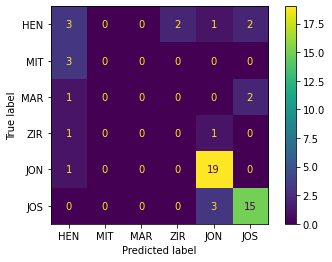

In [38]:
matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict), display_labels=labels)
matrix.plot()

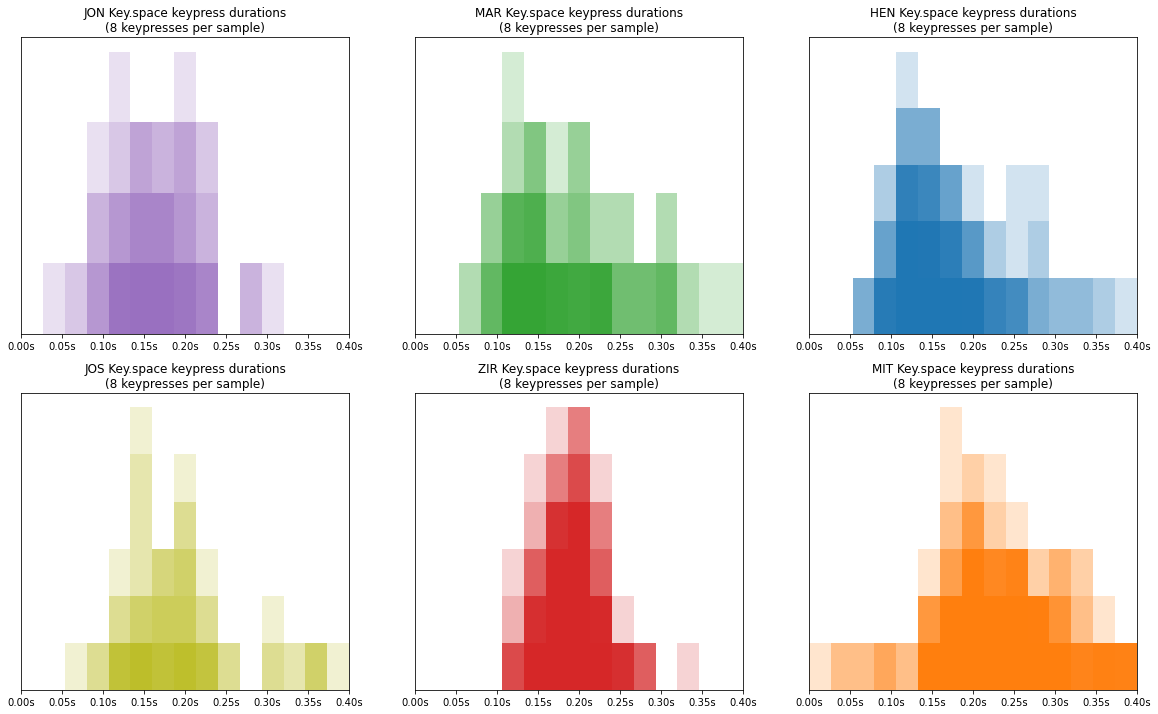

In [5]:

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive']

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

for i, j in product([0, 1], [0, 1, 2]):

    # 0-5 given i and j
    index = (i - 2 * j) + 4

    key = keys[0]

    kb = log_parser.parse_keyboard_log(f"logs/{labels[index]}/SOL/key.log")
    kb = kb[kb.key == key] # Isolate key press/releases that we care about

    durations = []
    presstime = -1
    
    for _, row in kb.iterrows():
        if row.action == 'pressed':
            presstime = row.time
        elif row.action == 'released' and presstime != -1:
            duration = row.time - presstime
            if duration < 0.4: # Only append key taps (<0.4s)
                durations.append(duration)
            if len(durations) == sample_size:
                ax[i][j].hist(durations, bins=15, range=(0, 0.4), alpha=0.2, color=colors[index])
                durations = [] # Reset durations

    ax[i][j].set_xlim(0, 0.4)
    ax[i][j].tick_params('y', left=False, labelleft=False)
    ax[i][j].xaxis.set_major_formatter(FormatStrFormatter("%.2fs"))
    ax[i][j].set_title(f'{labels[index]} {keys[0]} keypress durations\n({sample_size} keypresses per sample)')


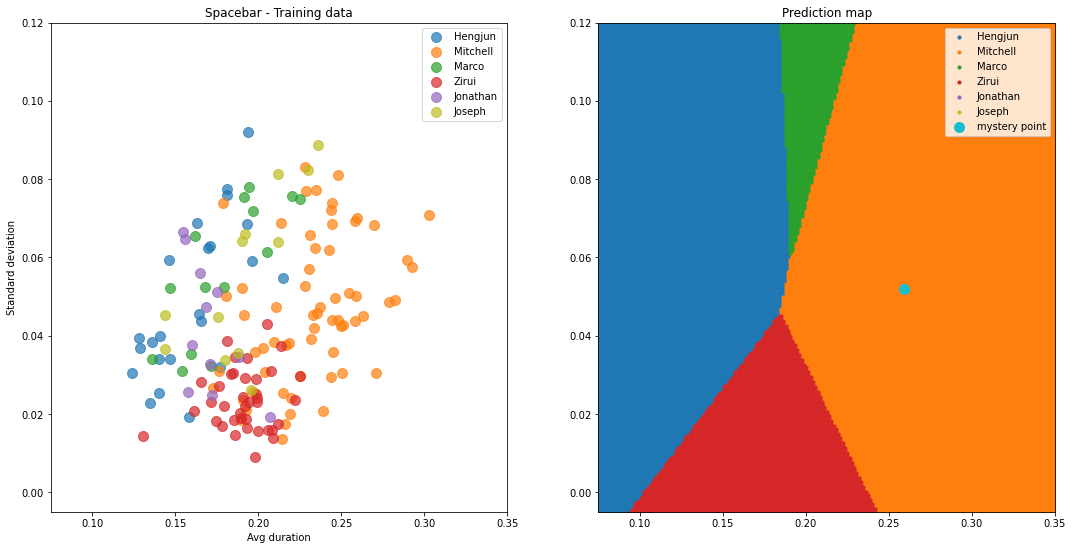

In [39]:
x_min = 0.075
x_max = 0.35
y_min = -.005
y_max = 0.12

fig, ax = plt.subplots(ncols=2, figsize=(18, 9))

ax[0].set_title("Spacebar - Training data")
ax[0].scatter(X_train[y_train == 'HEN'][:, 0], X_train[y_train == 'HEN'][:, 1], alpha=0.7, s=100, c="tab:blue", label="Hengjun")
ax[0].scatter(X_train[y_train == 'MIT'][:, 0], X_train[y_train == 'MIT'][:, 1], alpha=0.7, s=100, c="tab:orange", label="Mitchell")
ax[0].scatter(X_train[y_train == 'MAR'][:, 0], X_train[y_train == 'MAR'][:, 1], alpha=0.7, s=100, c="tab:green", label="Marco")
ax[0].scatter(X_train[y_train == 'ZIR'][:, 0], X_train[y_train == 'ZIR'][:, 1], alpha=0.7, s=100, c="tab:red", label="Zirui")
ax[0].scatter(X_train[y_train == 'JON'][:, 0], X_train[y_train == 'JON'][:, 1], alpha=0.7, s=100, c="tab:purple", label="Jonathan")
ax[0].scatter(X_train[y_train == 'JOS'][:, 0], X_train[y_train == 'JOS'][:, 1], alpha=0.7, s=100, c="tab:olive", label="Joseph")
ax[0].set_xlabel('Avg duration')
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylabel('Standard deviation')
ax[0].set_ylim(y_min, y_max)
ax[0].legend(loc='best')

"""

ax[1].set_title("Spacebar - Test data")
ax[1].scatter(X_test[y_test == 'HEN'][:, 0], X_test[y_test == 'HEN'][:, 1], alpha=0.7, s=100, c="tab:blue", label="Hengjun")
ax[1].scatter(X_test[y_test == 'MIT'][:, 0], X_test[y_test == 'MIT'][:, 1], alpha=0.7, s=100, c="tab:orange", label="Mitchell")
ax[1].scatter(X_test[y_test == 'MAR'][:, 0], X_test[y_test == 'MAR'][:, 1], alpha=0.7, s=100, c="tab:green", label="Marco")
ax[1].scatter(X_test[y_test == 'ZIR'][:, 0], X_test[y_test == 'ZIR'][:, 1], alpha=0.7, s=100, c="tab:red", label="Zirui")
ax[1].scatter(X_test[y_test == 'JON'][:, 0], X_test[y_test == 'JON'][:, 1], alpha=0.7, s=100, c="tab:purple", label="Jonathan")
ax[1].scatter(X_test[y_test == 'JOS'][:, 0], X_test[y_test == 'JOS'][:, 1], alpha=0.7, s=100, c="tab:olive", label="Joseph")
ax[1].set_xlabel('Avg duration')
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylabel('Standard deviation')
ax[1].set_ylim(y_min, y_max)
ax[1].legend(loc='best')

"""

# Making a fake dataset that covers the whole plot
wow = np.empty((1, 2))
point_size = 1
x_step = (x_max - x_min) / 200
y_step = (y_max - y_min) / 200
for i in np.arange(x_min, x_max + x_step, x_step):
    for j in np.arange(y_min, y_max + y_step, y_step):
        wow = np.append(wow, [[i, j]], axis=0)

# Predictions on that dataset
y_predict = model.predict(wow)

mystery_point_index = 1

# Plot predictions
ax[1].set_title("Prediction map")
ax[1].scatter(wow[:,0][y_predict=='HEN'], wow[:,1][y_predict=='HEN'], label='Hengjun', c='tab:blue', s=point_size * 10)
ax[1].scatter(wow[:,0][y_predict=='MIT'], wow[:,1][y_predict=='MIT'], label='Mitchell', c='tab:orange', s=point_size * 10)
ax[1].scatter(wow[:,0][y_predict=='MAR'], wow[:,1][y_predict=='MAR'], label='Marco', c='tab:green', s=point_size * 10)
ax[1].scatter(wow[:,0][y_predict=='ZIR'], wow[:,1][y_predict=='ZIR'], label='Zirui', c='tab:red', s=point_size * 10)
ax[1].scatter(wow[:,0][y_predict=='JON'], wow[:,1][y_predict=='JON'], label='Jonathan', c='tab:purple', s=point_size * 10)
ax[1].scatter(wow[:,0][y_predict=='JOS'], wow[:,1][y_predict=='JOS'], label='Joseph', c='tab:olive', s=point_size * 10)
ax[1].scatter(X_test[mystery_point_index, 0], X_test[mystery_point_index, 1], alpha=1, s=100, c="tab:cyan", label="mystery point")
ax[1].legend(loc='best')
ax[1].set_ylim(y_min, y_max)
ax[1].set_xlim(x_min, x_max); # Semicolon stops this line from showing up in output


In [7]:
from log_parser import parse_keyboard_log, extract_keyboard_features

key = "r"

hen = extract_keyboard_features(parse_keyboard_log("logs/HEN/SOL/key.log"), 0, 3600)
print(f"Hengjun {key} presses:", hen[hen.key == key]['count'].to_list()[0])

mit = extract_keyboard_features(parse_keyboard_log("logs/MIT/SOL/key.log"), 0, 3600)
print(f"Mitchell {key} presses:", mit[mit.key == key]['count'].to_list()[0])

mar = extract_keyboard_features(parse_keyboard_log("logs/MAR/SOL/key.log"), 0, 3600)
print(f"Marco {key} presses:", mar[mar.key == key]['count'].to_list()[0])

zir = extract_keyboard_features(parse_keyboard_log("logs/ZIR/SOL/key.log"), 0, 3600)
print(f"Zirui {key} presses:", zir[zir.key == key]['count'].to_list()[0])

jon = extract_keyboard_features(parse_keyboard_log("logs/JON/SPY/key.log"), 0, 3600)
print(f"Jonathan {key} presses:", jon[jon.key == key]['count'].to_list()[0])

jos = extract_keyboard_features(parse_keyboard_log("logs/JOS/SOL/key.log"), 0, 3600)
print(f"Joseph {key} presses:", jos[jos.key == key]['count'].to_list()[0])

print("Hengjun:")
display(hen)
print("Mitchell:")
display(mit)
print("Marco:")
display(mar)
print("Zirui:")
display(zir)
print("Jonathan:")
display(jon)
print("Joseph:")
display(jos)

Hengjun r presses: 1
Mitchell r presses: 16
Marco r presses: 31
Zirui r presses: 35
Jonathan r presses: 4
Joseph r presses: 106
Hengjun:


,key,count,avg_duration,freq,class
0,w,509,2.539585,0.141389,HENSOL
1,d,635,0.718861,0.176389,HENSOL
2,a,808,0.704536,0.224444,HENSOL
3,s,288,0.859650,0.080000,HENSOL
4,Key.tab,123,2.272844,0.034167,HENSOL
5,Key.space,291,0.264105,0.080833,HENSOL
6,Key.ctrl_l,15,1.360133,0.004167,HENSOL
7,q,1,0.090700,0.000278,HENSOL
8,r,1,0.140300,0.000278,HENSOL
9,t,1,0.116400,0.000278,HENSOL


Mitchell:


,key,count,avg_duration,freq,class
0,d,1161,0.568955,0.322500,MITSOL
1,w,1059,1.641318,0.294167,MITSOL
2,s,774,0.565060,0.215000,MITSOL
3,a,1464,0.547015,0.406667,MITSOL
4,Key.space,685,0.242554,0.190278,MITSOL
5,r,16,0.108644,0.004444,MITSOL
6,Key.tab,10,3.818290,0.002778,MITSOL
7,z,2,0.096100,0.000556,MITSOL
8,2,16,0.095988,0.004444,MITSOL
9,1,5,0.098420,0.001389,MITSOL


Marco:


,key,count,avg_duration,freq,class
0,w,869,1.991657,0.241389,MARSOL
1,Key.tab,95,1.850739,0.026389,MARSOL
2,q,346,0.078039,0.096111,MARSOL
3,d,1695,0.399565,0.470833,MARSOL
4,a,1645,0.381838,0.456944,MARSOL
5,s,666,0.484204,0.185000,MARSOL
6,Key.space,139,0.214733,0.038611,MARSOL
7,e,5,0.073100,0.001389,MARSOL
8,r,31,0.068426,0.008611,MARSOL
9,Key.ctrl_l,55,0.544153,0.015278,MARSOL


Zirui:


,key,count,avg_duration,freq,class
0,w,620,2.572880,0.172222,ZIRSOL
1,a,922,0.777419,0.256111,ZIRSOL
2,d,820,0.735468,0.227778,ZIRSOL
3,Key.space,450,0.191533,0.125000,ZIRSOL
4,s,419,0.670188,0.116389,ZIRSOL
5,r,35,0.147411,0.009722,ZIRSOL
6,Key.tab,1,0.123500,0.000278,ZIRSOL


Jonathan:


,key,count,avg_duration,freq,class
0,w,614,1.772522,0.170556,JONSPY
1,a,917,0.353108,0.254722,JONSPY
2,4,82,0.103894,0.022778,JONSPY
3,Key.ctrl_l,164,3.678912,0.045556,JONSPY
4,d,753,0.325410,0.209167,JONSPY
5,s,230,0.599214,0.063889,JONSPY
6,1,14,0.117829,0.003889,JONSPY
7,6,20,0.097985,0.005556,JONSPY
8,Key.space,128,0.201249,0.035556,JONSPY
9,3,40,0.110173,0.011111,JONSPY


Joseph:


,key,count,avg_duration,freq,class
0,w,666,2.347357,0.185000,JOSSOL
1,a,1141,0.652197,0.316944,JOSSOL
2,d,924,0.626228,0.256667,JOSSOL
3,s,367,1.016974,0.101944,JOSSOL
4,r,106,0.116152,0.029444,JOSSOL
5,Key.space,156,0.409511,0.043333,JOSSOL
6,3,3,0.128033,0.000833,JOSSOL
7,1,3,0.111733,0.000833,JOSSOL
8,Key.tab,30,2.934187,0.008333,JOSSOL
9,h,1,0.127700,0.000278,JOSSOL


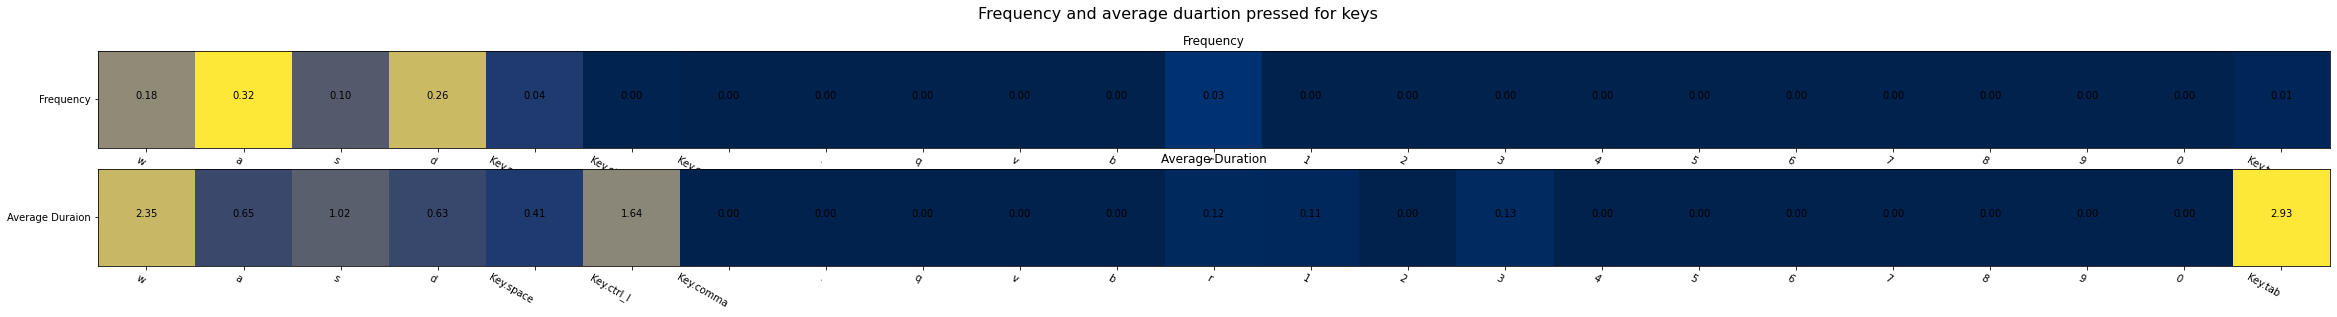

In [8]:
from log_parser import parse_keyboard_log
from keyboard_heatmap import KeyboardHeatmap

heatmap = KeyboardHeatmap(parse_keyboard_log("logs/JOS/SOL/key.log"), 0, 3600)
heatmap.show_infographic()